In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import ks_2samp, entropy

def jensen_shannon_distance(p, q):
    """
    Compute the Jensen-Shannon divergence between two probability distributions.

    Parameters:
        p, q (numpy.array): Two probability distributions (each should sum to 1).

    Returns:
        float: Jensen-Shannon divergence.
    """
    m = 0.5 * (p + q)
    return 0.5 * entropy(p, m) + 0.5 * entropy(q, m)

def compute_drift_numeric(train_series, test_series, bins=50):
    """
    Compute drift metrics between training and test data for a numeric feature.

    Parameters:
        train_series (pd.Series): Training data for a feature.
        test_series (pd.Series): Test/production data for the feature.
        bins (int): Number of bins for histogram computation.

    Returns:
        tuple: (ks_stat, p_value, js_div, bin_edges, hist_train, hist_test)
    """
    # Remove missing values
    train_clean = train_series.dropna()
    test_clean = test_series.dropna()

    # Perform the KS test to compare distributions
    ks_stat, p_value = ks_2samp(train_clean, test_clean)

    # Determine common histogram range based on both datasets
    min_val = min(train_clean.min(), test_clean.min())
    max_val = max(train_clean.max(), test_clean.max())

    # Compute normalized histograms (density=True ensures they sum to 1)
    hist_train, bin_edges = np.histogram(train_clean, bins=bins, range=(min_val, max_val), density=True)
    hist_test, _ = np.histogram(test_clean, bins=bins, range=(min_val, max_val), density=True)

    # Avoid zeros in histograms for divergence calculation
    hist_train = hist_train + 1e-10
    hist_test = hist_test + 1e-10

    # Compute Jensen-Shannon divergence
    js_div = jensen_shannon_distance(hist_train, hist_test)

    return ks_stat, p_value, js_div, bin_edges, hist_train, hist_test

def plot_drift(feature_name, train_series, test_series, bins=50):
    """
    Plot and compare the distributions of a feature from training and test datasets.

    Parameters:
        feature_name (str): The name of the feature.
        train_series (pd.Series): Training data for the feature.
        test_series (pd.Series): Test/production data for the feature.
        bins (int): Number of bins for histogram plotting.

    Returns:
        tuple: (ks_stat, p_value, js_div)
    """
    ks_stat, p_value, js_div, bin_edges, _, _ = compute_drift_numeric(train_series, test_series, bins)

    plt.figure(figsize=(10, 6))
    plt.hist(train_series.dropna(), bins=bin_edges, alpha=0.5, label='Train', density=True)
    plt.hist(test_series.dropna(), bins=bin_edges, alpha=0.5, label='Test', density=True)
    plt.title(f"Drift in '{feature_name}'\nKS p-value: {p_value:.4f}, JS Divergence: {js_div:.4f}")
    plt.xlabel(feature_name)
    plt.ylabel('Density')
    plt.legend()
    plt.show()

    return ks_stat, p_value, js_div


Testing on 4 Different Datasets:

The function simulate_dataset generates four datasets with increasing drift levels (from no drift to severe drift) using different seeds.
Each dataset is used to compute drift metrics on the same feature (feature1).
Quantitative Evaluation Metrics:

The proposed method computes the Kolmogorov–Smirnov (KS) statistic and Jensen–Shannon (JS) divergence to quantify drift.
The baseline method uses the relative difference in means (normalized by the training standard deviation) to detect drift.
These metrics are output numerically and summarized in a comparison table.


Visualizing drift for Dataset 1 with drift level 0


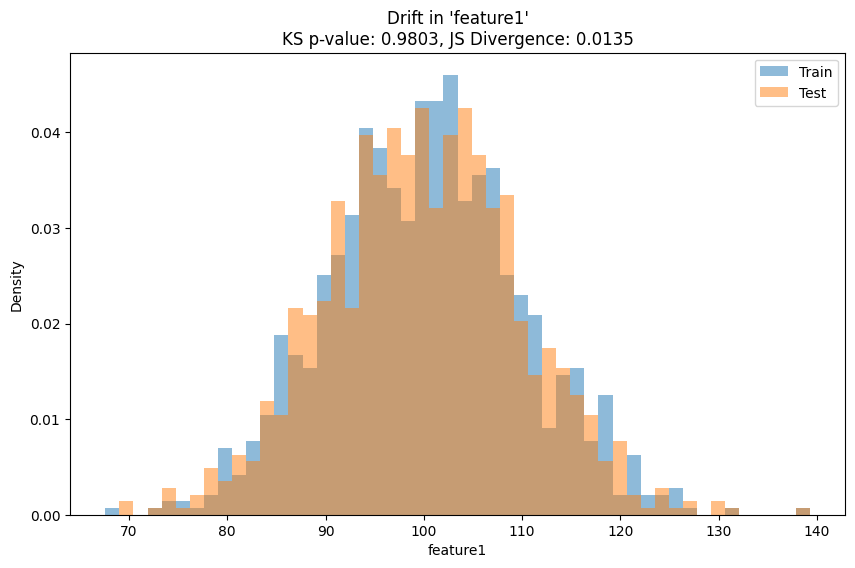


Visualizing drift for Dataset 2 with drift level 5


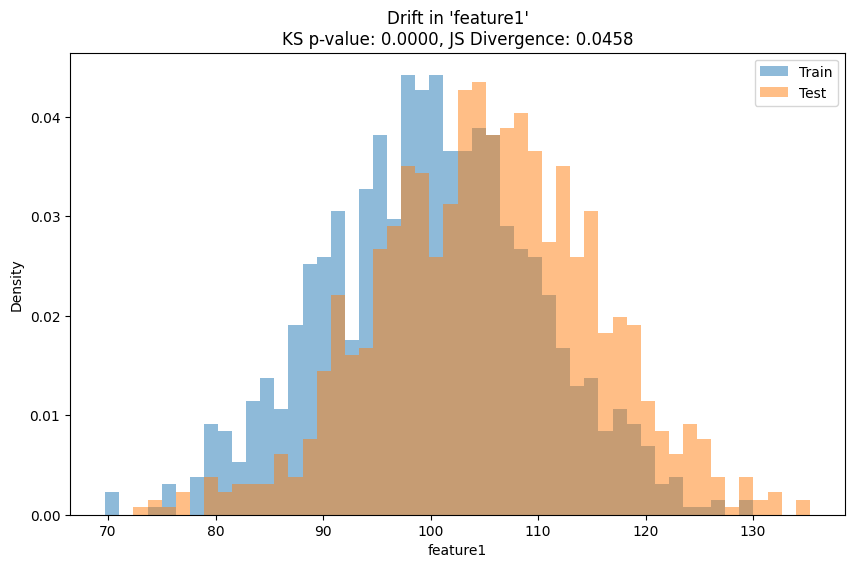


Visualizing drift for Dataset 3 with drift level 10


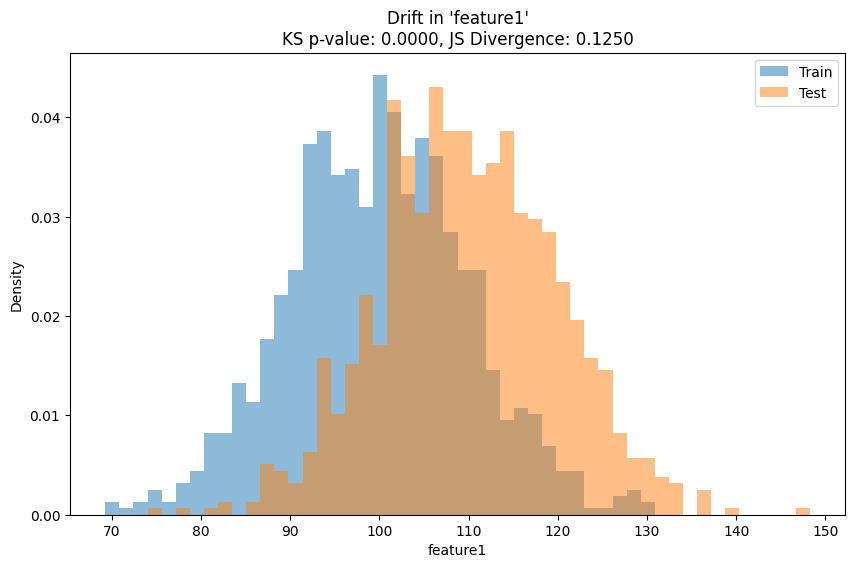


Visualizing drift for Dataset 4 with drift level 20


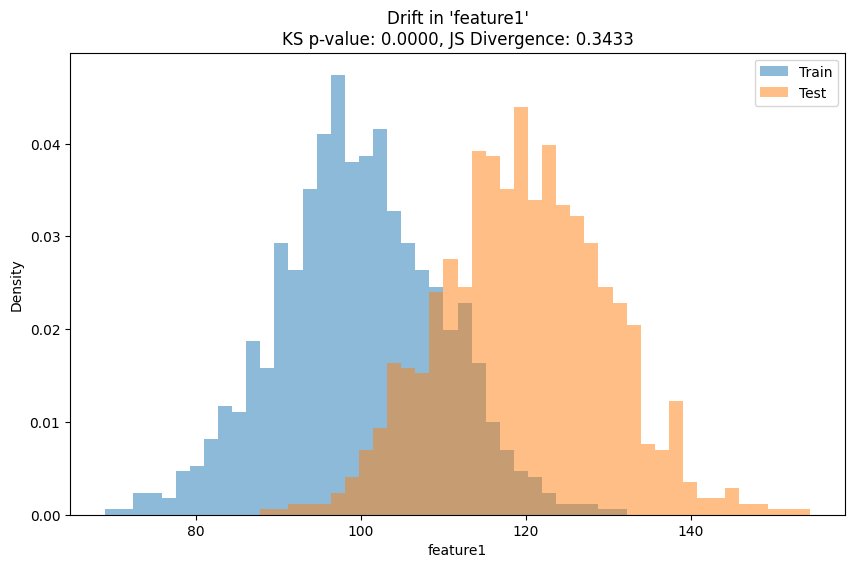


Drift Detection Evaluation Results:
     Dataset  Drift_Level  Proposed_KS  Proposed_JS  Baseline_RelDiff  \
0  Dataset 1            0        0.021       0.0135            0.0138   
1  Dataset 2            5        0.221       0.0458            0.5288   
2  Dataset 3           10        0.385       0.1250            1.0013   
3  Dataset 4           20        0.679       0.3433            2.0267   

   Baseline_Flag  
0          False  
1           True  
2           True  
3           True  


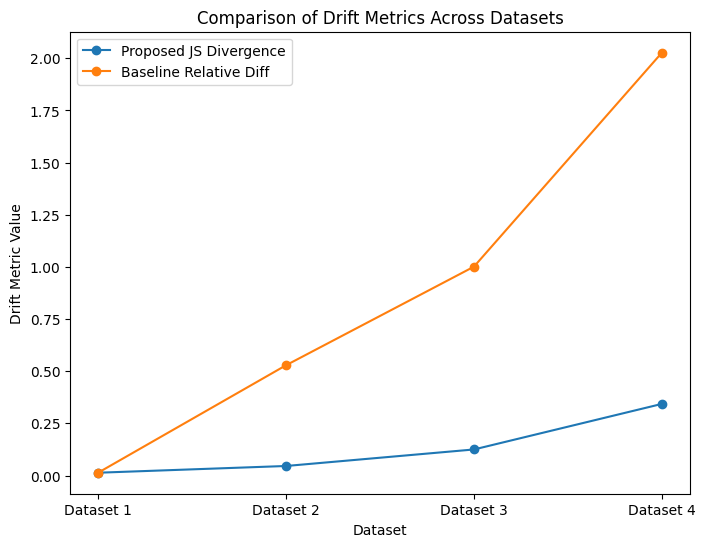

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def baseline_drift_detection(train_series, test_series, threshold=0.1):
    """
    A simple baseline approach that detects drift based on the relative difference in means.

    Parameters:
        train_series (pd.Series): Training data for a feature.
        test_series (pd.Series): Test/production data for the feature.
        threshold (float): Threshold on the normalized difference to flag drift.

    Returns:
        tuple: (drift_flag, relative_difference)
            drift_flag (bool): True if the relative difference exceeds the threshold.
            relative_difference (float): Absolute difference in means normalized by training std.
    """
    mean_train = train_series.mean()
    mean_test = test_series.mean()
    std_train = train_series.std()
    relative_diff = abs(mean_test - mean_train) / std_train
    drift_flag = relative_diff > threshold
    return drift_flag, relative_diff

def simulate_dataset(seed, drift_level):
    """
    Simulate a dataset with a specific level of drift on 'feature1'.

    Parameters:
        seed (int): Random seed for reproducibility.
        drift_level (float): Amount to shift the mean in the test data to simulate drift.

    Returns:
        tuple: (train_data, test_data) as pandas DataFrames.
    """
    np.random.seed(seed)
    # Simulate training data with fixed parameters
    train_data = pd.DataFrame({
        'feature1': np.random.normal(loc=100, scale=10, size=1000),
        'feature2': np.random.normal(loc=50, scale=5, size=1000)
    })
    # Simulate test data with drift introduced in feature1
    test_data = pd.DataFrame({
        'feature1': np.random.normal(loc=100 + drift_level, scale=10, size=1000),
        'feature2': np.random.normal(loc=50, scale=5, size=1000)
    })
    return train_data, test_data

def evaluate_on_datasets():
    # Define 4 datasets with different drift levels in 'feature1'
    dataset_specs = [
        {'seed': 42, 'drift_level': 0},    # No drift
        {'seed': 43, 'drift_level': 5},    # Mild drift
        {'seed': 44, 'drift_level': 10},   # Moderate drift
        {'seed': 45, 'drift_level': 20}    # Severe drift
    ]

    results = []
    for i, spec in enumerate(dataset_specs, start=1):
        train_data, test_data = simulate_dataset(spec['seed'], spec['drift_level'])

        # Apply the proposed method on feature1
        ks_stat, p_value, js_div, _, _, _ = compute_drift_numeric(train_data['feature1'], test_data['feature1'])

        # Apply the baseline approach on feature1
        drift_flag, rel_diff = baseline_drift_detection(train_data['feature1'], test_data['feature1'])

        # Store results for later comparison
        results.append({
            'Dataset': f'Dataset {i}',
            'Drift_Level': spec['drift_level'],
            'Proposed_KS': round(ks_stat, 4),
            'Proposed_JS': round(js_div, 4),
            'Baseline_RelDiff': round(rel_diff, 4),
            'Baseline_Flag': drift_flag
        })

        # Visualize drift detection for this dataset
        print(f"\nVisualizing drift for Dataset {i} with drift level {spec['drift_level']}")
        plot_drift('feature1', train_data['feature1'], test_data['feature1'])

    # Create a DataFrame summarizing the results
    results_df = pd.DataFrame(results)
    print("\nDrift Detection Evaluation Results:")
    print(results_df)

    # Plot a comparison of the proposed and baseline drift metrics
    plt.figure(figsize=(8, 6))
    plt.plot(results_df['Dataset'], results_df['Proposed_JS'], marker='o', label='Proposed JS Divergence')
    plt.plot(results_df['Dataset'], results_df['Baseline_RelDiff'], marker='o', label='Baseline Relative Diff')
    plt.xlabel('Dataset')
    plt.ylabel('Drift Metric Value')
    plt.title('Comparison of Drift Metrics Across Datasets')
    plt.legend()
    plt.show()

if __name__ == '__main__':
    evaluate_on_datasets()


Image 1: Visualizing Drift for Dataset 1 (Drift Level 0)
Scenario:
In this dataset, no drift is introduced. Both training and test data for the feature (e.g., "feature1") have the same statistical distribution.

Visualization Details:

Histograms Overlap: The training and test histograms overlap almost perfectly.
Metrics:
KS Statistic: Very low (around 0.021)
JS Divergence: Extremely low (around 0.0135)
Baseline Relative Difference: Minimal (around 0.0138)
Interpretation:
These low values confirm that there is virtually no change between the two distributions. In practical terms, the model’s input distribution is consistent, and you wouldn’t expect any negative impact on performance due to drift.





Image 2: Visualizing Drift for Dataset 2 (Drift Level 5)
Scenario:
Here, a mild drift is simulated by shifting the mean of the test data by 5 units relative to the training data.

Visualization Details:

Histogram Shift:
The test data histogram shows a slight rightward shift compared to the training data.
The two histograms still have some overlap, but the separation is noticeable.
Metrics:
KS Statistic: Increased (around 0.221)
JS Divergence: Also increased (around 0.0458)
Baseline Relative Difference: Noticeably higher (around 0.5288), with the baseline flag marking drift.
Interpretation:
The metrics and visual separation indicate that drift is present. Although the change isn’t dramatic, it’s sufficient to be flagged by both the proposed method and the simple baseline. This mild drift could potentially start affecting model predictions if it continues or intensifies.






Image 3: Visualizing Drift for Dataset 3 (Drift Level 10)
Scenario:
A moderate drift is introduced by shifting the test data distribution by 10 units relative to the training data.

Visualization Details:

Histogram Shift:
The test histogram is clearly displaced to the right of the training histogram.
There is less overlap between the two distributions.
Metrics:
KS Statistic: Moderately high (around 0.385)
JS Divergence: Increases further (around 0.1250)
Baseline Relative Difference: Significantly higher (around 1.0013), with drift flagged.
Interpretation:
The noticeable shift in the histograms, combined with the higher divergence and KS values, suggests that the data distribution is moderately different from the original. This level of drift is likely to impact the model’s performance, making it a clear signal that retraining or adaptation might be necessary.







Image 4: Visualizing Drift for Dataset 4 (Drift Level 20)
Scenario:
A severe drift is simulated by shifting the test data by 20 units relative to the training data.

Visualization Details:






Histogram Shift:
The test histogram is largely separated from the training histogram, with very little overlap.
Metrics:
KS Statistic: Very high (around 0.679)
JS Divergence: Also very high (around 0.3433)
Baseline Relative Difference: Extremely high (around 2.0267), clearly flagging drift.
Interpretation:
The drastic shift indicates that the test data distribution has changed considerably. Such a severe drift would likely have a major impact on model predictions. This visualization clearly demonstrates that the model is no longer receiving data similar to what it was trained on, necessitating immediate corrective actions like retraining or model adjustments.
Overall Summary
Progression of Drift:
The images show a clear progression:

Dataset 1: No drift, distributions are nearly identical.
Dataset 2: Mild drift, slight shift detectable.
Dataset 3: Moderate drift, clear separation starts to emerge.
Dataset 4: Severe drift, almost no overlap between distributions.
Metrics Correlation:
The quantitative metrics (KS statistic, JS divergence, and baseline relative difference) increase with the drift level, confirming the visual observations. This helps in objectively comparing the performance of the proposed drift detection approach against a simple baseline.

Practical Implications:
These visual and quantitative results are crucial for decision-making in a production environment. They indicate when a model might start to underperform due to changing data distributions and therefore when intervention (like model retraining) is needed.